In [1]:
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial.distance import hamming
from sklearn.externals import joblib
import csv
import matplotlib.pyplot as plt
from LearningDataAdapter import LearningDataAdapter
from ModelEvaluator import ModelEvaluator
from sklearn.metrics import roc_curve
import glob
from LearningScore import learning_curve
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr
from matplotlib.backends.backend_pdf import PdfPages

Importing test sample... 

Plotting ROC curve...

Plotting probability distribution...

Plotting learning curve......
Importing training data...
Calculating learning curves...
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


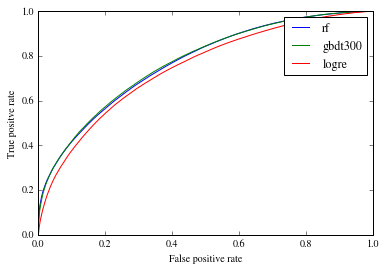

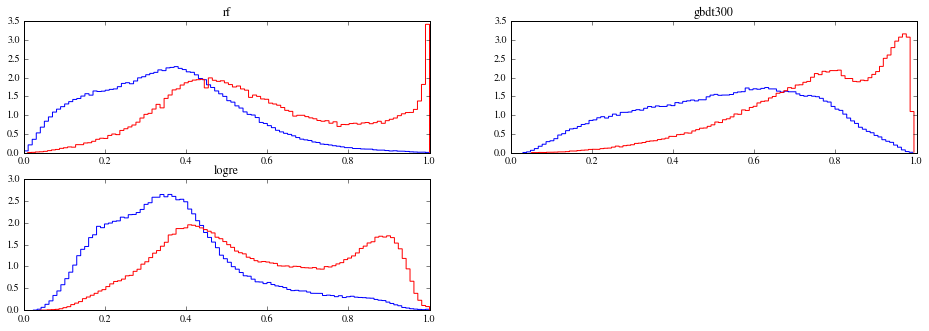

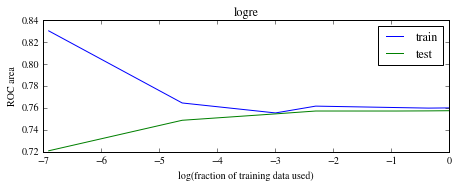

In [2]:
%matplotlib inline

# obtain valid data
print 'Importing test sample... '
adapter = LearningDataAdapter(for_learning=True)
adapter.adapt_file('data/validate.csv')
X_num, X_cat = adapter.X_num, adapter.X_cat

imp = joblib.load("./models/imputer.pkl")
scaler = joblib.load("./models/scaler.pkl")
enc = joblib.load("./models/encoder.pkl")
evaluator = ModelEvaluator(
imputer=imp, scaler=scaler,
encoder=enc)

pred_x = evaluator.preprocess(X_num,X_cat)
pred_w, pred_y = adapter.w, adapter.y
print


# plot
# this step will plot ROC curve, probability distribution for signal/background
# and learning curve for each model.

print 'Plotting ROC curve...'
plt.figure(1)    
model_list = glob.glob('./models/*.pkl')
for model in model_list:
    if model not in ['./models/encoder.pkl','./models/scaler.pkl','./models/imputer.pkl']:
        rf = joblib.load(model)
        evaluator = ModelEvaluator(
        imputer=imp, scaler=scaler,
        encoder=enc, model=rf
        )

        #y_pred = evaluator.predict(X_num, X_cat)
        prob1 = evaluator.predict_proba(X_num, X_cat)[:,1]
        fpr,tpr,thresholds = roc_curve(pred_y, prob1, sample_weight=pred_w)
        plt.plot(fpr,tpr,label=model[9:-4])
        plt.xlabel('False positive rate')
        plt.ylabel('True positve rate')

plt.legend()
pp = PdfPages('roc.pdf')
pp.savefig()
pp.close()
print


print 'Plotting probability distribution...'
plt.figure(2,figsize=(16,8))
number_of_models = len(model_list)
count = 0
for model in model_list:
    if model not in ['./models/encoder.pkl','./models/scaler.pkl','./models/imputer.pkl']:
        count = count + 1
        rf = joblib.load(model)
        evaluator = ModelEvaluator(
        imputer=imp, scaler=scaler,
        encoder=enc, model=rf
        )

        prob1 = evaluator.predict_proba(X_num, X_cat)[:,1]
        signal = prob1[pred_y==1]
        background = prob1[pred_y==0]
        plt.subplot(len(model_list)/2, 2, count)
        plt.hist(background,color='b',bins=100,normed='true',histtype='step')
        plt.hist(signal,color='r',bins=100,normed='true',histtype='step')
        plt.title(model[9:-4])
pp = PdfPages('density_plot.pdf')
pp.savefig()
pp.close()
print



print 'Plotting learning curve......'
plt.figure(3,figsize=(16,8))
print 'Importing training data...'
adapter.adapt_file('data/train.csv')
X_num, X_cat = adapter.X_num, adapter.X_cat
evaluator = ModelEvaluator(
imputer=imp, scaler=scaler,
encoder=enc)
train_w, train_y = adapter.w, adapter.y
train_x = evaluator.preprocess(X_num,X_cat)

print 'Calculating learning curves...'
number_of_models = len(model_list)
count = 0
#for model in model_list:
for model in ['./models/logre.pkl']:
    if model not in ['./models/encoder.pkl','./models/scaler.pkl','./models/imputer.pkl']:
        count = count + 1
        plt.subplot(len(model_list)/2, 2, count)
        rf = joblib.load(model)
        print rf
        lcr = learning_curve(train_x,train_y,train_w,pred_x,pred_y,pred_w,rf)
        train_size, train_list, test_list = lcr.learning_curve()
        plt.plot(np.log(train_size),train_list,label='train')
        plt.plot(np.log(train_size),test_list,label='test')
        plt.xlabel('log(fraction of training data used)')
        plt.ylabel('ROC area')
        plt.title(model[9:-4])

plt.legend()
pp = PdfPages('learning_curve.pdf')
pp.savefig()
pp.close()

Importing training data...
Calculate Information Gain...


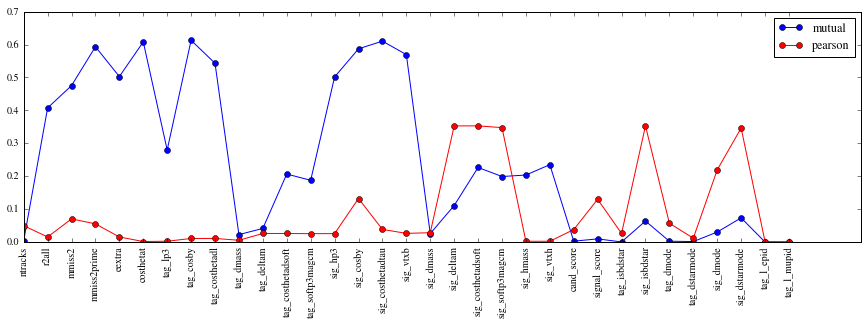

In [3]:
%matplotlib inline
print 'Importing training data...'
with open('./data/train.csv') as f_train:
	f_iter = csv.reader(f_train,delimiter=',')
	data_list = [i for i in f_iter]

data_np = np.array(data_list[1:],dtype=float)
feature_name = data_list[0]

label = data_np[:,-1]
for i in range(len(label)):
	if (label[i] in [11445, 11447]):
		label[i] = 1
	else:
		label[i] = 0


# remove eid, cidx, weight, and label
data_np = data_np[:,2:-2]
feature_name = feature_name[2:-2]


print 'Calculate Information Gain...'
mutual = []
correlation = []
for i in range(len(feature_name)):
	mutual_info = mutual_info_score(data_np[:,i],label)
	corr_info = abs(pearsonr(data_np[:,i],label)[0])
	mutual.append(mutual_info)
	correlation.append(corr_info)


#plot
x = range(len(mutual))
plt.figure(1,figsize=(15,8))
plt.plot(x,mutual,'b-o',label='mutual')
plt.plot(x,correlation,'r-o',label='pearson')
plt.xticks(x, feature_name, rotation='vertical')
plt.subplots_adjust(bottom=0.5)
plt.legend()
pp = PdfPages('relative_importance.pdf')
pp.savefig()
pp.close()